Instruction to Run Code:


*   Use GPU


## Imports

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import h5py

# FOr data visualisations & graphs
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset 
from torch import optim

import cv2
from tqdm.notebook import tqdm
import datetime 
from IPython.display import HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


shape of the training data is  (1006, 450, 500)


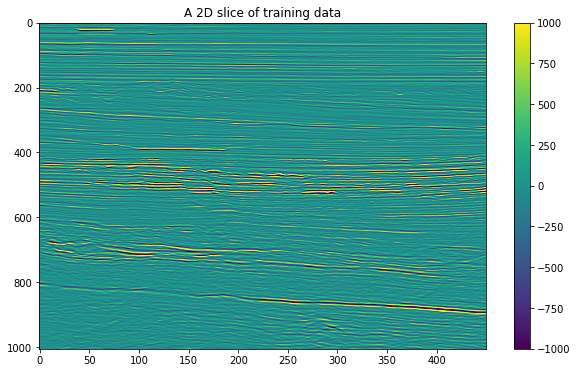

shape of the training labels is  (1006, 450, 500)


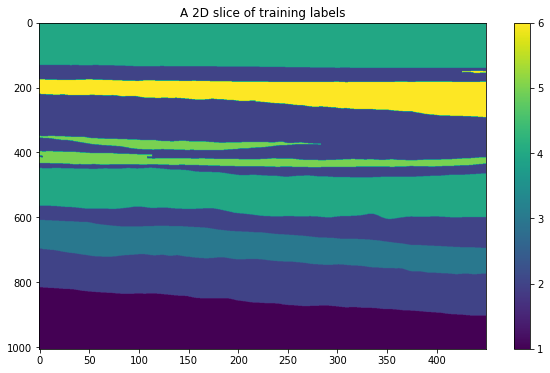

shape of the test data is  (1006, 50, 500)


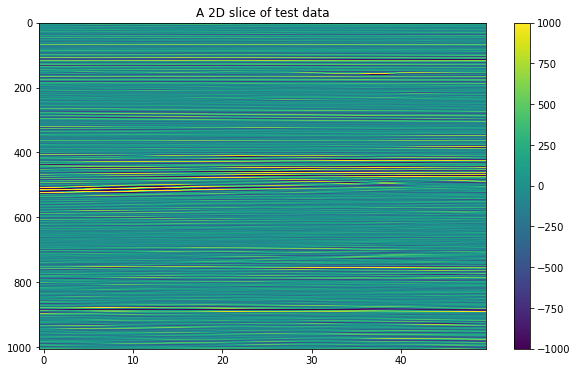

In [ ]:
## read training data

hf=h5py.File('/content/drive/My Drive/AGP_Hackathon/train_data_seismic.h5','r')
train_data=hf['train_data'][()]
hf.close()
print('shape of the training data is ',train_data.shape)
plt.figure(figsize=(10,6))
plt.imshow(train_data[:,:,24],aspect='auto',vmin=-1000,vmax=1000)
plt.colorbar()
plt.title('A 2D slice of training data')
plt.show()


## read training labels

hf=h5py.File('/content/drive/My Drive/AGP_Hackathon/train_label_facies.h5','r')
train_labels=hf['train_labels'][()]
hf.close()
print('shape of the training labels is ',train_labels.shape)
plt.figure(figsize=(10,6))
plt.imshow(train_labels[:,:,24],aspect='auto')
plt.colorbar()
plt.title('A 2D slice of training labels')
plt.show()


## read test data

hf=h5py.File('/content/drive/My Drive/AGP_Hackathon/test_data_seismic.h5','r')
test_data=hf['test_data'][()]
hf.close()
print('shape of the test data is ',test_data.shape)
plt.figure(figsize=(10,6))
plt.imshow(test_data[:,:,24],aspect='auto',vmin=-1000,vmax=1000)
plt.colorbar()
plt.title('A 2D slice of test data')
plt.show()

X_train = train_data
Y_train train_labels

## Utils

###  *U-Net** model 


1.   UNet is a convolutional neural network architecture that expanded with few changes in the CNN architecture.
2.   a convolutional autoencoder with additional connections between the encoder and the decoder parts.
3. State of the art for Image segmentation.
4. Encoder embeds data to a lower dimnesion and decoder produces a reconstruction. The focus to extract important features in the data while balancing the it and handling outliers rather than perfect reconstruction of input data. 



In [ ]:
## DoubleConv Class to perform two layer Convolution

class DoubleConv(nn.Module):                                                             
    def __init__(self,in_ch,out_ch):
        super(DoubleConv,self).__init__()                                                 
        self.conv = nn.Sequential(
                nn.Conv2d(in_ch,out_ch,3,padding=1), 
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True),
                nn.Conv2d(out_ch,out_ch,3,padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True)
            )
    def forward(self,x):
        return self.conv(x)


## UNet Class with shown architecture

class UNet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(UNet,self).__init__()
        
        ## Encoder Architecture (Downsampling)
        self.conv1 = DoubleConv(in_ch,64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64,128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128,256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256,512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512,1024)
      
        ## Decoder Architecture (Upsampling)
        self.up6 = nn.ConvTranspose2d(1024,512,2,stride=2)
        self.conv6 = DoubleConv(1024,512)
        self.up7 = nn.ConvTranspose2d(512,256,2,stride=2)
        self.conv7 = DoubleConv(512,256)
        self.up8 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.conv8 = DoubleConv(256,128)
        self.up9 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.conv9 = DoubleConv(128,128)
        self.conv9 = DoubleConv(128,64)
        self.conv10 = nn.Conv2d(64,out_ch,1)
 
    def forward(self,x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6,c4],dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7,c3],dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8,c2],dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9,c1],dim=1)
        c9 = self.conv9(merge9)
        out = c9
        c10 = self.conv10(c9)
        out = c10        
        out = nn.Softmax()(c10) 
        return out

### Dice Loss


*   The Dice coefficient is a common metric for pixel segmentation that can also be modified to act as a loss function, called the dice loss.
*   Multi Class dice loss is carried out by one hot encoding. It applies the DiceLoss on each class iteratively.






In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
      super(DiceLoss, self).__init__()
    def	forward(self, inputs, target):
      N = target.size(0)
      smooth = 1
      input_flat = inputs.view(N, -1)
      target_flat = target.view(N, -1)
  
      intersection = input_flat * target_flat
  
      loss = 2 * (intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
      loss = 1 - loss.sum() / N
  
      return loss
 
class MulticlassDiceLoss(nn.Module):
	"""
	Requires input.shape[0:1] and target.shape[0:1] to be (N, C) where N is
	  batch size and C is number of classes
	"""
	def __init__(self):
		super(MulticlassDiceLoss, self).__init__()
 
	def forward(self, inputs, target, weights=None):
        
		target = torch.nn.functional.one_hot(target.long()).permute(0,3,1,2)
		inputs = torch.nn.functional.softmax(inputs,dim=1)

		C = target.shape[1] 
		# if weights is None:
		# 	weights = torch.ones(C) #uniform weights for all classes
 
		dice = DiceLoss()
		totalLoss = 0
 
		for i in range(C):
			diceLoss = dice(inputs[:,i], target[:,i])
			if weights is not None:
				diceLoss *= weights[i]
			totalLoss += diceLoss
 
		return totalLoss

In [ ]:
class DataGenerator(Dataset):

    def __init__(self, x_set, y_set):
        self.x, self.y = x_set, y_set

    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        batch_x = self.x[index]
        batch_y = self.y[index]
        return np.expand_dims(batch_x,axis=0), batch_y

## Weight / Factor for Dice Loss Criterion
e=1e-2

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()


def train(model,optimizer,dataload,num_epochs,device):
    acc_history  = []
    loss_history = []
    miou_history = []
    for epoch in range(num_epochs):
        print('Starting epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        since = time.time()
        dataset_size = len(dataload.dataset)
        epoch_loss = 0
        epoch_acc  = 0

        for idx,(x, y) in enumerate(dataload):                 
            optimizer.zero_grad()             
            inputs = x.to(device)
            labels = y.to(device)
            outputs = model(inputs)           
            criterion1 = MulticlassDiceLoss() 
            loss1 = criterion1(outputs,labels.long())
            criterion2 = torch.nn.CrossEntropyLoss()
            loss2 = criterion2(torch.log(outputs),labels.long())

            ## using both loss functions for Image segmentation
            
            loss = e*loss1+loss2
            acc  = accuracy(outputs,labels)
            loss.backward()                  
            optimizer.step()                  
            
            epoch_loss += loss.item()
            epoch_acc+= acc
            loss_history.append(loss.item())
            acc_history.append(acc)
            if (idx+1)%10==0:
              print("%d/%d,train_loss:%0.3f,accuracy:%0.3f" % (idx+1, dataset_size // dataload.batch_size, loss.item(),acc))

        time_elapsed = time.time() - since     
        all_epoch_loss=epoch_loss/len(dataload)
        all_epoch_acc=epoch_acc/len(dataload)
        print("epoch %d loss:%0.3f accuracy:%0.3f " % (epoch, all_epoch_loss,all_epoch_acc))
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model,"/content/model_0.pth")      
    return model,loss_history,acc_history

In [1]:
## Function to make the final prediction on the test data

def seisfacies_predict(section,patch_size=256,overlap=0,onehot=0): 
    m1,m2 = section.shape
    os    = overlap                                 
    n1,n2 = 512,patch_size           
    c1 = int(np.round((m1+os)/(n1-os)+0.5))
    c2 = int(np.round((m2+os)/(n2-os)+0.5))
    p1 = (n1-os)*c1+os
    p2 = (n2-os)*c2+os

    gp = np.zeros((p1,p2),dtype=np.single)     
    gy = np.zeros((6,p1,p2),dtype=np.single)    
    gs = np.zeros((n1,n2),dtype=np.single) 
    
    gp[0:m1,0:m2]=section     

    for k1 in range(c1):
        for k2 in range(c2):
            b1 = k1*n1-k1*os
            e1 = b1+n1
            b2 = k2*n2-k2*os
            e2 = b2+n2                
            #predict
            gs[:,:]=gp[b1:e1,b2:e2]
            x=gs.reshape(1,1,512,256)
            Y_patch= model(torch.from_numpy(x)).squeeze()
            p=F.softmax(Y_patch, dim=0).detach().numpy()
            gy[:,b1:e1,b2:e2]= gy[:,b1:e1,b2:e2]+p
    
    gy_onehot = gy[:,0:m1,0:m2]            
    #onehot2label
    gy_label =np.argmax(gy_onehot,axis=0)

    if onehot==0:
        return gy_label
    if onehot==1:
        return gy_label,gy_onehot

## Training 

In [ ]:
print(X_train.shape , Y_train.shape)

Y_train[Y_train==6] = 0    ## Chaging Label 6 to 0 for zero based indexing

((1006, 450, 500), (1006, 450, 500))

In [ ]:
training_img_data = []
training_label_data = []

## Preparing 2D images by Slicing the 3D Seismic Data 

## Define the X lines slices for training
for i in tqdm(range(0, X_train.shape[1])):
  img = X_train[:, i, :]
  label = Y_train[:, i, :]

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (256, 512), interpolation=cv2.INTER_AREA)
  label = cv2.resize(label, (256, 512), interpolation = cv2.INTER_NEAREST)
  label = label.astype(int)
  
  training_img_data.append(img) 
  training_label_data.append(label)

## Define the Y lines slices for training
for i in tqdm(range(0, X_train.shape[2])):
  img = X_train[:, :, i]
  label = Y_train[:, :, i]

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (256, 512), interpolation=cv2.INTER_AREA)
  label = cv2.resize(label, (256, 512), interpolation = cv2.INTER_NEAREST)
  label = label.astype(int)

  training_img_data.append(img) 
  training_label_data.append(label)


  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
## Converting to np.array format 

training_img_data = np.asarray(training_img_data)
training_label_data = np.asarray(training_label_data)
training_label_data = np.array(training_label_data,dtype=int)
training_img_data.shape, training_label_data.shape

((950, 512, 256), (950, 512, 256))

In [ ]:
#np.unique(training_label_data)

In [ ]:
# from dice_loss import *

## Final Training

!CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(1,6).to(device)
train_dataset = DataGenerator(x_set=training_img_data,y_set=training_label_data) 
dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
# optimizer = optim.SGD(model.parameters(),lr=1e-2, momentum=0.9)
optimizer = optim.Adam(model_1.parameters(),lr=5e-2)
num_epochs=14
model_0,loss,acc=train(model,optimizer,dataloader,num_epochs,device)

Starting epoch 1/14
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


10/95,train_loss:1.556,accuracy:0.421
20/95,train_loss:1.387,accuracy:0.449
30/95,train_loss:1.241,accuracy:0.505
40/95,train_loss:1.197,accuracy:0.533
50/95,train_loss:1.127,accuracy:0.550
60/95,train_loss:1.033,accuracy:0.596
70/95,train_loss:0.906,accuracy:0.665
80/95,train_loss:0.730,accuracy:0.754
90/95,train_loss:0.641,accuracy:0.776
epoch 0 loss:1.135 accuracy:0.564 
Training complete in 1m 49s
Starting epoch 2/14
----------
10/95,train_loss:0.518,accuracy:0.824
20/95,train_loss:0.424,accuracy:0.860
30/95,train_loss:0.338,accuracy:0.895
40/95,train_loss:0.288,accuracy:0.923
50/95,train_loss:0.286,accuracy:0.917
60/95,train_loss:0.237,accuracy:0.936
70/95,train_loss:0.220,accuracy:0.944
80/95,train_loss:0.181,accuracy:0.955
90/95,train_loss:0.181,accuracy:0.954
epoch 1 loss:0.309 accuracy:0.908 
Training complete in 1m 48s
Starting epoch 3/14
----------
10/95,train_loss:0.160,accuracy:0.960
20/95,train_loss:0.152,accuracy:0.964
30/95,train_loss:0.147,accuracy:0.964
40/95,train_lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


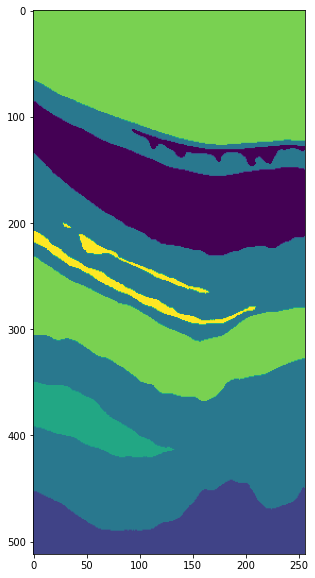

In [ ]:
## Prediction Visualization
model = torch.load("/content/model_0.pth",map_location='cpu')
gy_label,gy_onehot=seisfacies_predict(training_img_data[420],onehot=1)
plt.imshow(gy_label)

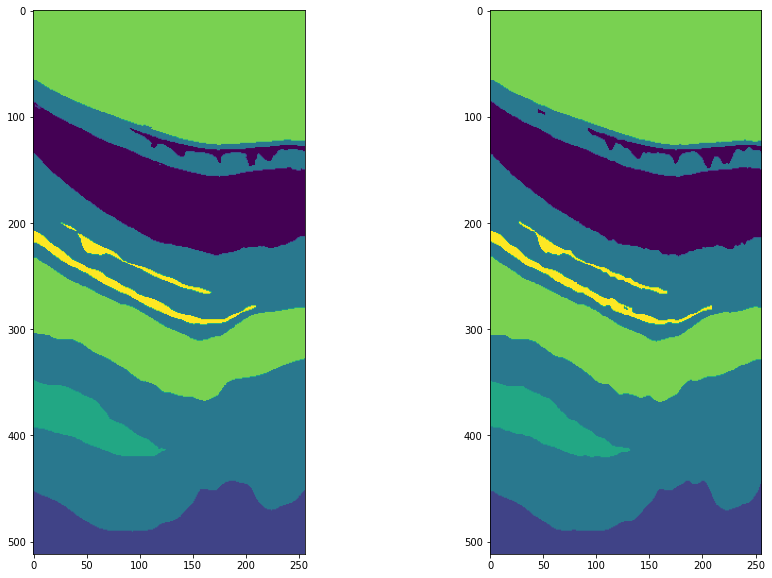

In [ ]:
## Comparing the actual and predicted seismic 2d sliced image

plt.rcParams["figure.figsize"] = (15, 10)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(gy_label)
axarr[1].imshow(training_label_data[420])

In [ ]:
# training_label_data[420]
#  gy_label
#  Y_train[:,:,420]

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
print('The amount of labels on the training label set was: {}.'.format(np.unique(gy_label)), 'The amount of labels on the predicted example is: {}'.format(np.unique(training_label_data[340])))

The amount of labels on the training label set was: [0 1 2 3 4 5]. The amount of labels on the predicted example is: [0 1 2 3 4 5]


## Predictions

In [ ]:
test_seismic = test_data
test_seismic.shape

In [ ]:
## Preparing 2D images by Slicing the 3D Seismic Data fro Test Data Set

testing_img_data = []
for i in tqdm(range(0, test_seismic.shape[1])):
  img = test_seismic[:,i,:]
  #img = img/MAX_AMP
  img = np.expand_dims(img, axis=2).astype('float32')
  img = cv2.resize(img, (256, 512))
  testing_img_data.append(img) 

for i in tqdm(range(0, test_seismic.shape[2])):
  img = test_seismic[:,:,i]
  #img = img/MAX_AMP
  img = np.expand_dims(img, axis=2).astype('float32')
  img = cv2.resize(img, (256, 512))
  testing_img_data.append(img) 


testing_img_data = np.asarray(testing_img_data)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
testing_img_data.shape

(550, 512, 256)

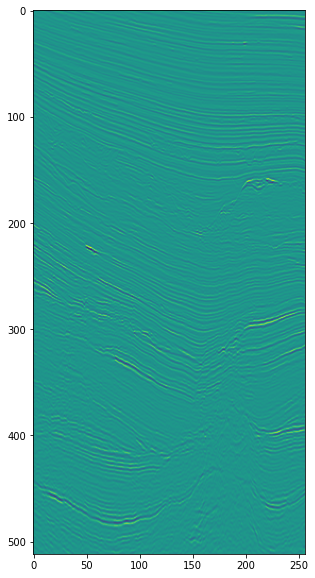

In [ ]:
# plt.imshow(testing_img_data[0])

In [ ]:
%%time
preds = []
for i in tqdm(range(0, test_seismic.shape[1])):
  gy_label,gy_onehot=seisfacies_predict(testing_img_data[i],onehot=1)
  preds.append(gy_label)

preds = np.asarray(preds)
print(preds.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


CPU times: user 6min 50s, sys: 10.9 s, total: 7min 1s
Wall time: 6min 59s


In [ ]:
## Reshaping function to match the dimensions of predicteion with the given test data 

def reshaping(data, out_shape):
  output_labels = []
  for i in data:
    img = np.expand_dims(i, axis=2).astype('float32')
    img = cv2.resize(img, out_shape)
    output_labels.append(img)
  output_labels = np.asarray(output_labels)
  output_labels = output_labels.astype(int) 
  return np.swapaxes(output_labels,0,1) 

In [ ]:
preds = reshaping(preds, (500,1006))
preds[preds == 0] = 6
print(preds.shape, np.unique(preds))

(1006, 50, 500) [1 2 3 4 5 6]


In [ ]:
# preds

array([[[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 

In [ ]:
## Saving the predictions
hf=h5py.File('predictions.h5','w')
hf.create_dataset("facies_predictions", data=preds, compression="gzip")
predictions=hf['facies_predictions'][()]
hf.close()

Optimizer : SGD
1. Learning Rate: 0.02, momentum = 0.9

Optimizer : Adam

1. Learning Rate: 0.01 : 
2. Learning Rate: 0.02 : 
3. Learning Rate: 0.05 : 
4. Learning Rate: 0.001 :

